In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [19]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, is_profit=False):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{setting_name}/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit_or_cost = []
    w_holding_by_warehouse_all = []
    return_data = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 50
            start_step = 30
        else:
            num_steps = 500
            start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        s_underage = relevant_data['s_underage_costs'].sum()
        s_holding = relevant_data['s_holding_costs'].sum()
        
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum())
        w_holding = sum(w_holding_costs)
        
        avg_s_underage.append(s_underage)
        avg_s_holding.append(s_holding)
        w_holding_by_warehouse_all.append(w_holding_costs)
        avg_w_holding.append(w_holding)
        
        if is_profit:
            # For profit: negate underage (revenue) and subtract costs
            profit = -s_underage - s_holding - w_holding
            avg_profit_or_cost.append(profit)
        else:
            # For loss: sum all costs
            cost = s_underage + s_holding + w_holding
            avg_profit_or_cost.append(cost)

        return_data.append(data)

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        
    metric_name = 'avg_profit' if is_profit else 'avg_lost_sales'
    df_copy[metric_name] = avg_profit_or_cost
    df = df_copy

    # Calculate relative metric as percentage of best value
    if is_profit:
        best_value = df[metric_name].max()
        df['relative_metric'] = df[metric_name] / best_value * 100
    else:
        best_value = df[metric_name].min()
        df['relative_metric'] = df[metric_name] / best_value * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    axes = axes.flatten()
    
    metric_title = 'Profit' if is_profit else 'Loss'
    titles = [f'{metric_title} (% of {"maximum" if is_profit else "minimum"})', 
              'Store Revenue(1e7)' if is_profit else 'Store Lost Sales(1e7)', 
              'Store Holding Cost(1e7)', 
              'Total Warehouse Holding Cost(1e7)', 
              'Individual Warehouse Holding Costs(1e7)']
    y_values = ['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], 
                                     linestyle=linestyle_scheme[arch], marker='o', markersize=10))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-1], titles[:-1], y_values)):
        for arch in df['Architecture Class'].unique():
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'relative_metric':
                    plot_values = plot_values / 1e7
                x_values = np.ones_like(plot_values)
                ax.plot(x_values, plot_values, marker='o', markersize=10,
                       color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([])

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch], linestyle=linestyle_scheme[arch])

    axes[-1].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    return return_data


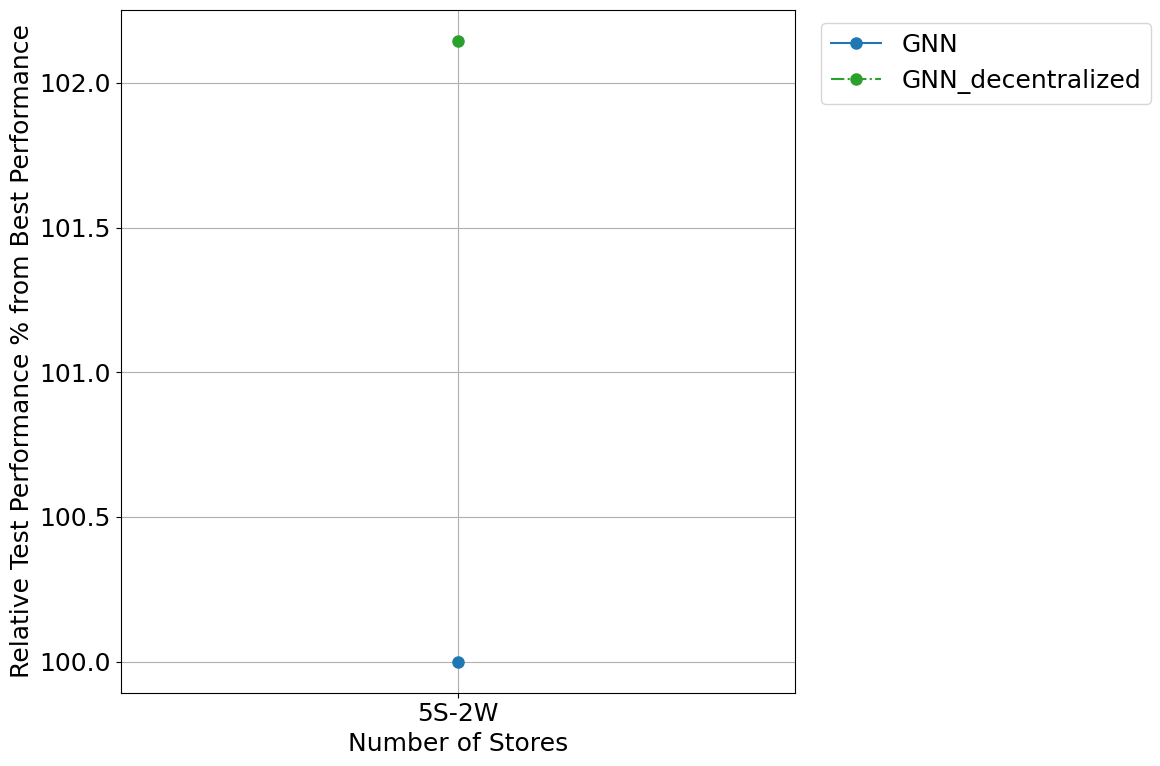

In [4]:
testset_names = ["separated_networks"]
results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

color_scheme = {
    "GNN": "#1f77b4",         # Blue
    "GNN_bottleneck": "#ff7f0e",    # Orange
    "GNN_decentralized": "#2ca02c", # Green
    "vanilla_n_warehouses": "#d62728", # Red
    "GNN_skip_connection": "#9467bd"  # Purple
}

linestyle_scheme = {
    "GNN": "-",         # Solid
    "GNN_bottleneck": "--",   # Dashed
    "GNN_decentralized": "-.", # Dashed-dotted
    "vanilla_n_warehouses": ":", # Dotted
    "GNN_skip_connection": "--"  # Dashed
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    # "GNN_bottleneck": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_bottleneck',
    "GNN_decentralized": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_decentralized',
    # "vanilla_n_warehouses": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/vanilla_n_warehouses',
    # "GNN_skip_connection": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_skip_connection',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
sample_size = [128]
dfs = []

for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        for size in sample_size:
            path = path_fn(testset_name)
            
            df = results_interpretor.make_table({1: path}, {'train_dev_sample_and_batch_size': [size]},
                default_condition_setter, custom_data_filler,
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                test_loss_limit = 100)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['n_warehouses'] = 2
            df['n_stores'] = 5
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss
store_size = 5  # We only have data for 5 stores
store_data = df[df['n_stores'] == store_size].copy()
best_test_loss = store_data['Test Loss'].min()
store_data.loc[:, 'Relative Test Performance %'] = (store_data['Test Loss'] / best_test_loss) * 100

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot points for each architecture
for arch in store_data['Architecture Class'].unique():
    arch_data = store_data[store_data['Architecture Class'] == arch]
    if not arch_data.empty:
        plt.plot(store_size, arch_data['Relative Test Performance %'].iloc[0],
                marker="o",
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                markersize=8,
                label=arch)

plt.xlabel('Number of Stores', fontsize=FONTSIZE)
plt.ylabel('Relative Test Performance % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.02, 1),
          loc='upper left', 
          fontsize=FONTSIZE)

plt.xticks([store_size], [f'{store_size}S-2W'], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [3]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,GNN,1024,GNN,0.001,8.252117,8.247755,8.242467,20,/user/ml4723/Prj/NIC/ray_results/separated_net...,2,5
1,1,GNN,128,GNN,0.001,8.248143,8.333053,8.280507,6,/user/ml4723/Prj/NIC/ray_results/separated_net...,2,5
2,1,GNN_decentralized,1024,GNN_decentralized,0.001,8.320681,8.308594,8.302854,19,/user/ml4723/Prj/NIC/ray_results/separated_net...,2,5
3,1,GNN_decentralized,128,GNN_decentralized,0.001,8.453395,8.526143,8.458067,12,/user/ml4723/Prj/NIC/ray_results/separated_net...,2,5


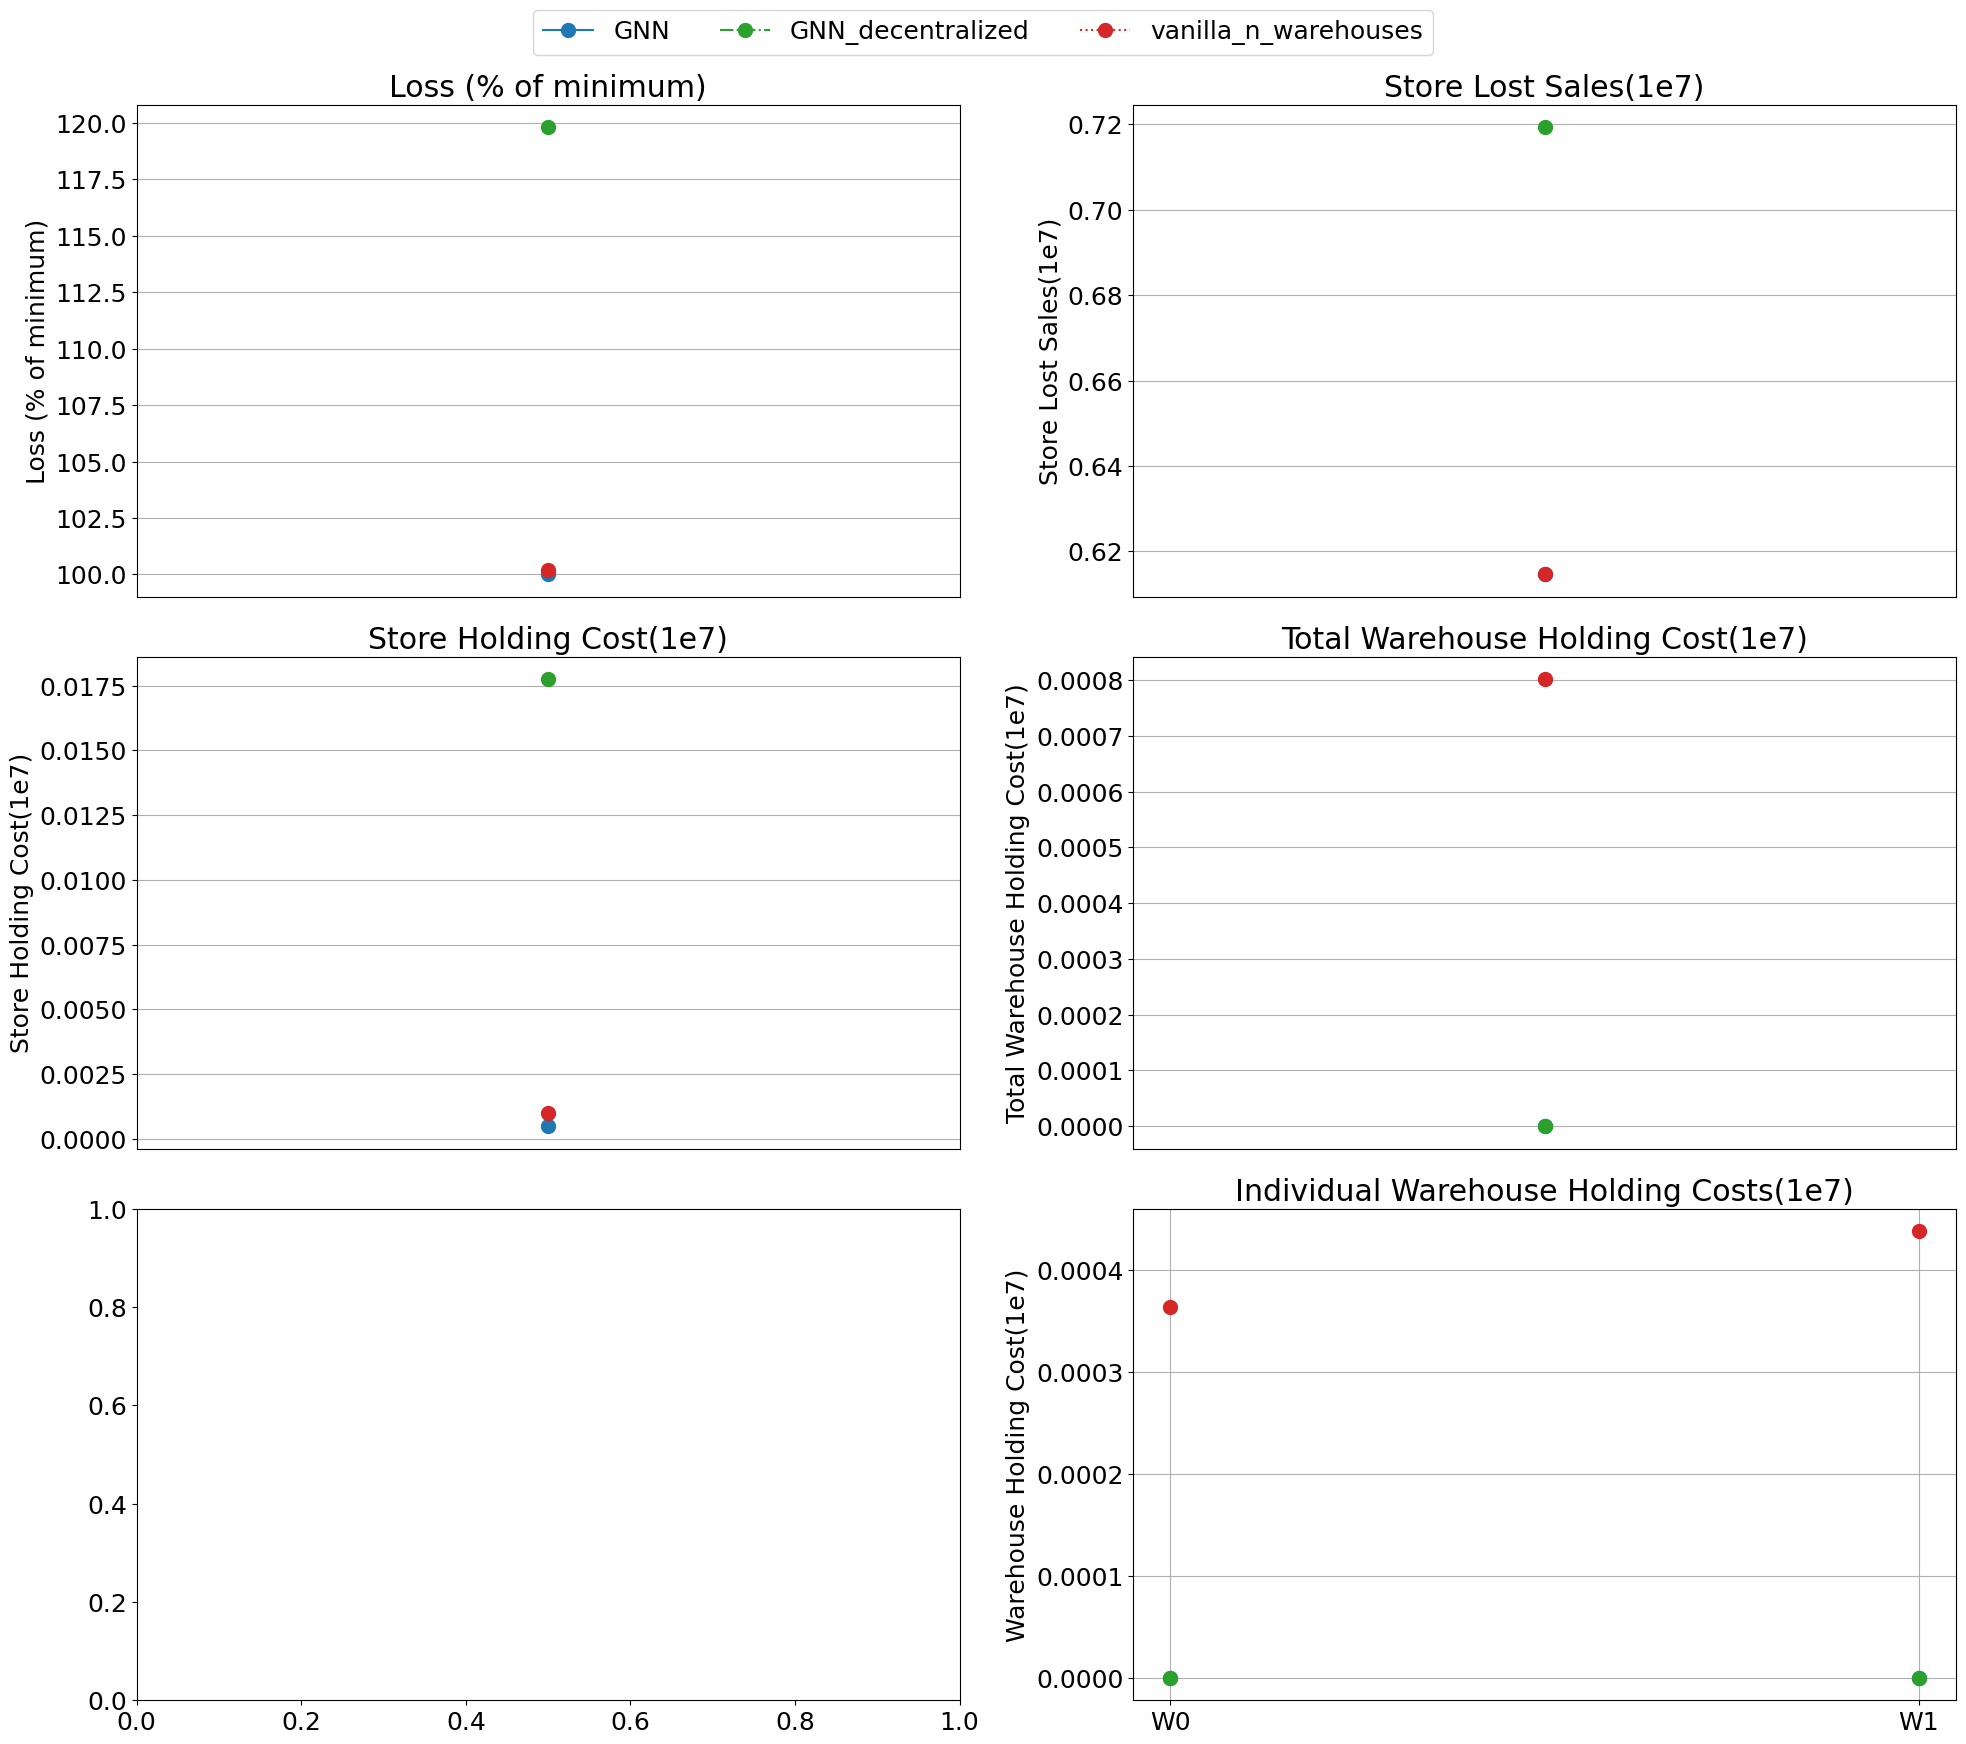

In [26]:
data = collect_data_and_plot(df, 5, 2, sample_size, "test", "separated_networks")

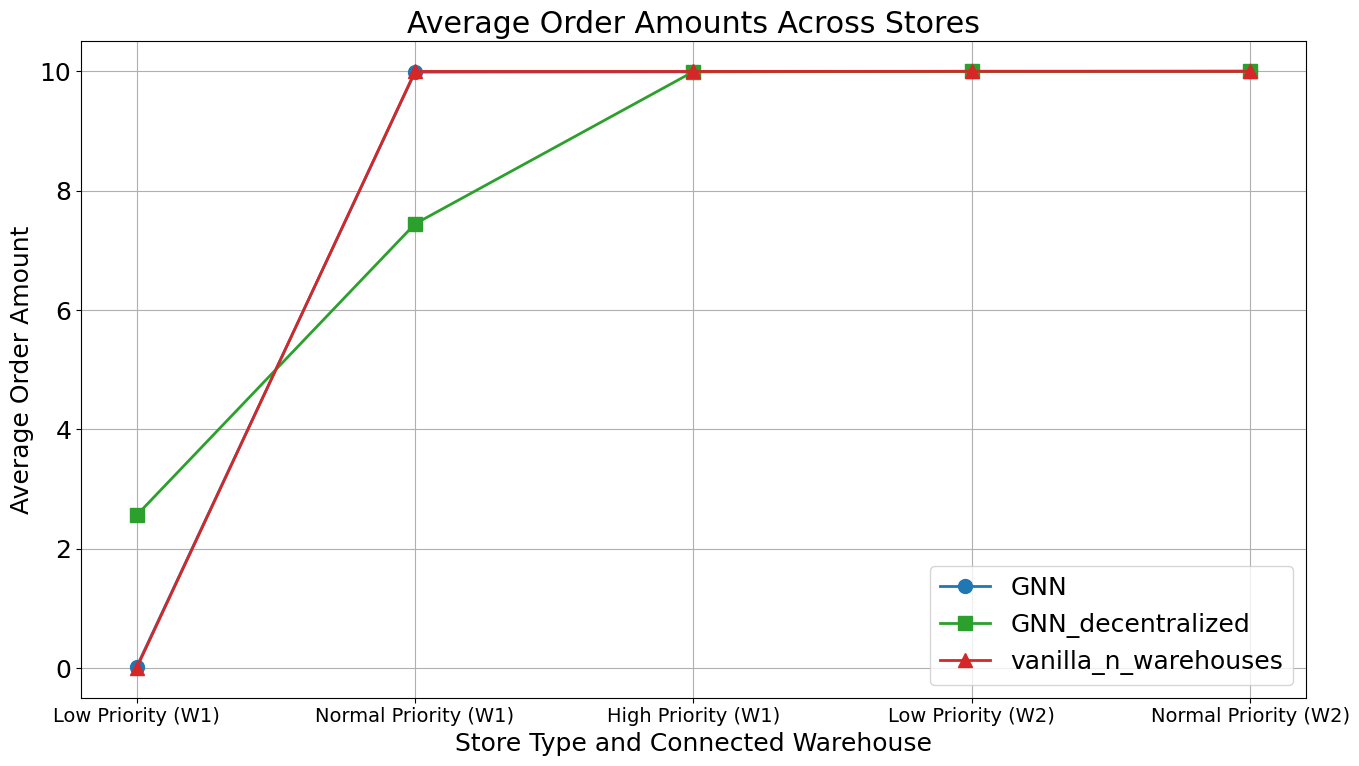


Average Order Amounts by Architecture and Store:
                      Low Priority (W1)  Normal Priority (W1)  High Priority (W1)  Low Priority (W2)  Normal Priority (W2)
GNN                                0.02                  9.99                9.99               10.0                  10.0
GNN_decentralized                  2.56                  7.44                9.99               10.0                  10.0
vanilla_n_warehouses               0.00                 10.00               10.00               10.0                  10.0


In [27]:
arch_names = ['GNN', 'GNN_decentralized', 'vanilla_n_warehouses']
markers = ['o', 's', '^', 'x']  # Circle, square, triangle, x

n_stores = 5
n_warehouses = 2
plt.figure(figsize=(14, 8))

inventories_dict = {}

# Define store labels
store_labels = [
    'Low Priority (W1)',
    'Normal Priority (W1)', 
    'High Priority (W1)',
    'Low Priority (W2)',
    'Normal Priority (W2)'
]
for arch_name, marker in zip(arch_names, markers):
    target_data = data[arch_names.index(arch_name)]
    n_periods = len(target_data) // sample_size
    
    store_inventories = [[] for _ in range(n_stores)]
    for store_idx in range(n_stores):
        period_indices = np.arange(sample_size, len(target_data))
        inventories = target_data[f's_{store_idx}_w_0_order'].iloc[period_indices].values + target_data[f's_{store_idx}_w_1_order'].iloc[period_indices].values
        store_inventories[store_idx].extend(inventories)
    store_inventories_result = [np.mean(store_inventories[i]) for i in range(n_stores)]
    inventories_dict[arch_name] = store_inventories_result
    
    plt.plot(range(n_stores), store_inventories_result, marker=marker,
             color=color_scheme[arch_name], linewidth=2, markersize=10,
             label=arch_name)

plt.xlabel('Store Type and Connected Warehouse')
plt.ylabel('Average Order Amount')
plt.title('Average Order Amounts Across Stores')
plt.grid(True)
plt.legend(loc='best')
plt.xticks(range(n_stores), store_labels, fontsize=14)
plt.tight_layout()
plt.show()
# Create and display pandas DataFrame of order amounts
df_result = pd.DataFrame(inventories_dict, index=store_labels).round(2).T
print("\nAverage Order Amounts by Architecture and Store:")
print(df_result.to_string())